# Compare Simple atmospheric libradtran with pyextinction

===========================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/20
- last update : 2023/10/21

===========================================================================



In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table

import pickle
import seaborn as sns
import copy
import astropy.io.fits as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
from libradtranpy import  libsimulateVisible

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def readOzoneTemplatexy(ozoneName,
                      colLbda='LAMBDA', colTrans='OZONE', ext=1):
    """
    Read ozone transmission template, interpolate over
    wavelengthes, and convert to extinction [mag/airmass].

    :param ozoneName: input FITS table, with columns *colLbda*
      (wavelength in AA) and *colTrans* (fractional transmission), and
      key 'REFO3COL' specifing the reference ozone column density [DU]
    :param lbda: output wavelengthes [AA]
    :param colLbda: name of the wavelength (in AA) column
    :param colTrans: name of the ozone transmission column
    :param ext: extension in which to look for wavelength and
      transmission columns
    :return: ozone extinction [mag/airmass], refO3col
    """

    # Read wavelength and transmission columns
    ffile = F.open(ozoneName)
    x = ffile[ext].data.field(colLbda)   # Wavelength
    y = ffile[ext].data.field(colTrans)  # Transmission
    refO3col = ffile[ext].header["REFO3COL"]
    return x,y,refO3col

# Configuration

In [6]:
WL = np.arange(300.,1100.)

In [7]:
AIRMASSMIN=1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [8]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [9]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

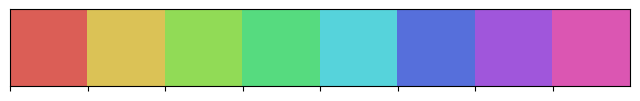

In [10]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

## PyExtinction initialisation

In [11]:
from pyextinction.AtmosphericExtinction import ExtinctionModel,EXT2OPT

In [12]:
pyExt_model = ExtinctionModel(WL*10.)

In [13]:
# Default ozone template
#pyE_O3Template = os.path.join(os.path.dirname(os.path.abspath(__file__)),'o3data/ozoneTemplate.fits')
pyE_O3Template = '/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/libradtranpy/src/pyextinction/o3data/ozoneTemplate.fits'

In [14]:
pyE_press = 740
pyE_o3 = 600.
pyE_tau = 0.05
pyE_ang = 1.3
pyE_pars = np.array([pyE_press,pyE_o3,pyE_tau,pyE_ang])
pyE_label1='pyExt Rayleigh [%.0f mbar]' % pyE_press
pyE_label2='pyExt Ozone [%.0f DU]' % pyE_o3
pyE_label3=u'pyExt Aerosols [τ=%.4f, å=%.2f]' % (pyE_tau, pyE_ang)
pyE_all_labels = [pyE_label1,pyE_label2,pyE_label3]

In [15]:
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions

In [16]:
pyE_xO3ref,pyE_yO3ref,pyE_refO3col = readOzoneTemplatexy(pyE_O3Template)
pyE_labelO3_ref = f"pyExt Ozone ref {pyE_refO3col} DU"

In [17]:
pyExt_model.__str__()

'Wavelength domain: 3000.0-10990.0 A by step of 10.0 A (800 px)\nOzone template: /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/AtmEmulator/src/pyextinction/o3data/ozoneTemplate.fits (265.0 DU)\nAerosol reference wavelength: 10000 A\nInput extinction parameters:\n  Pressure: 740 +/- 0 mbar\n  Ozone:    600 +/- 0 DU\n  Aerosols: optical depth @ refLbda: 0.05 +/- 0\n            angstrom exponent:         1.30 +/- 0.00\n'

## Check emulator with Rayleigh scattering

In [18]:
pressure = 0. # use default value
pwv=4       # turn on or of the pwv
aer=0  
ozone=0.    # turn on or of the ozone
cloudext=0

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

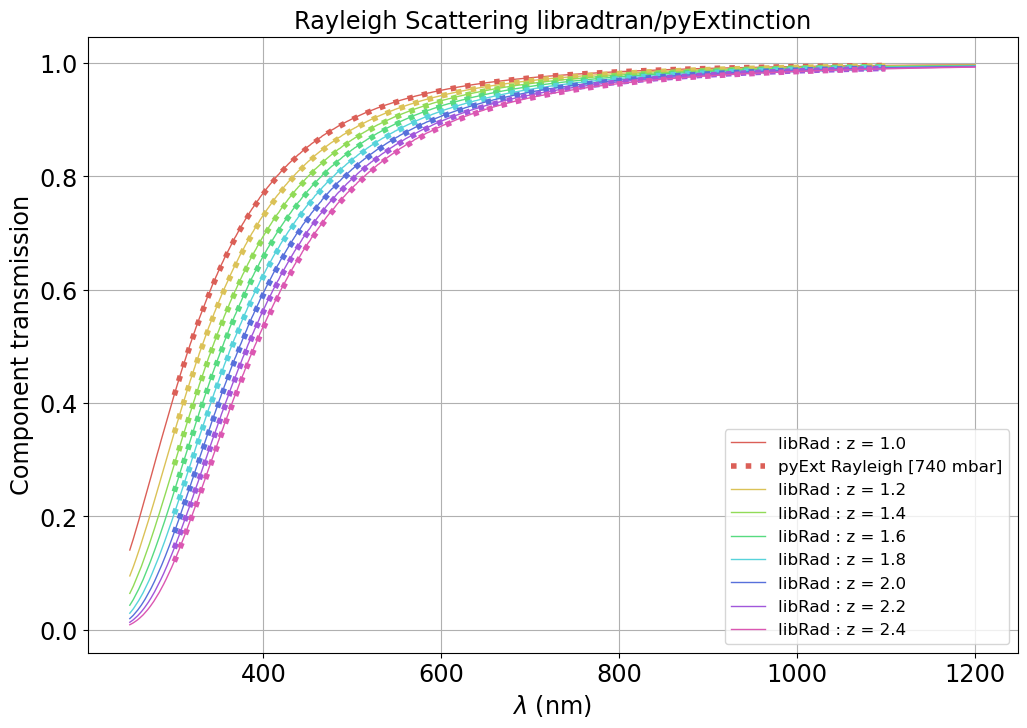

In [19]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()
for idx,am in enumerate(airmasses):

    path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,
                                                      prof_str='us',proc_str='sc',cloudext=cloudext)
    data = np.loadtxt(os.path.join(path,thefile))
    wl = data[:,0]
    transm = data[:,1] 
    
    label = f"libRad : z = {am:.1f}"
    ax.plot(wl,transm,'-',color=hls_colors[idx],label=label,lw=1)
    if idx==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[0,:]*am),":",color=hls_colors[idx],lw=4,label=pyE_label1)
    else:
        ax.plot(WL,np.exp(-pyE_opticalindexes[0,:]*am),":",color=hls_colors[idx],lw=4)
ax.set_ylabel("Component transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title("Rayleigh Scattering libradtran/pyExtinction")
ax.grid()

## Check emulator with Ozone absorption

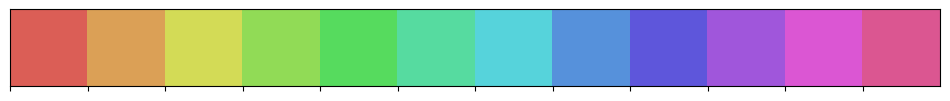

In [20]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

In [21]:
airmass = 1
pressure = 0. # use default value
pwv=0       # turn on or of the pwv
aer=0  
ozone=0.    # turn on or of the ozone
cloudext=0

(0.9, 1.025)

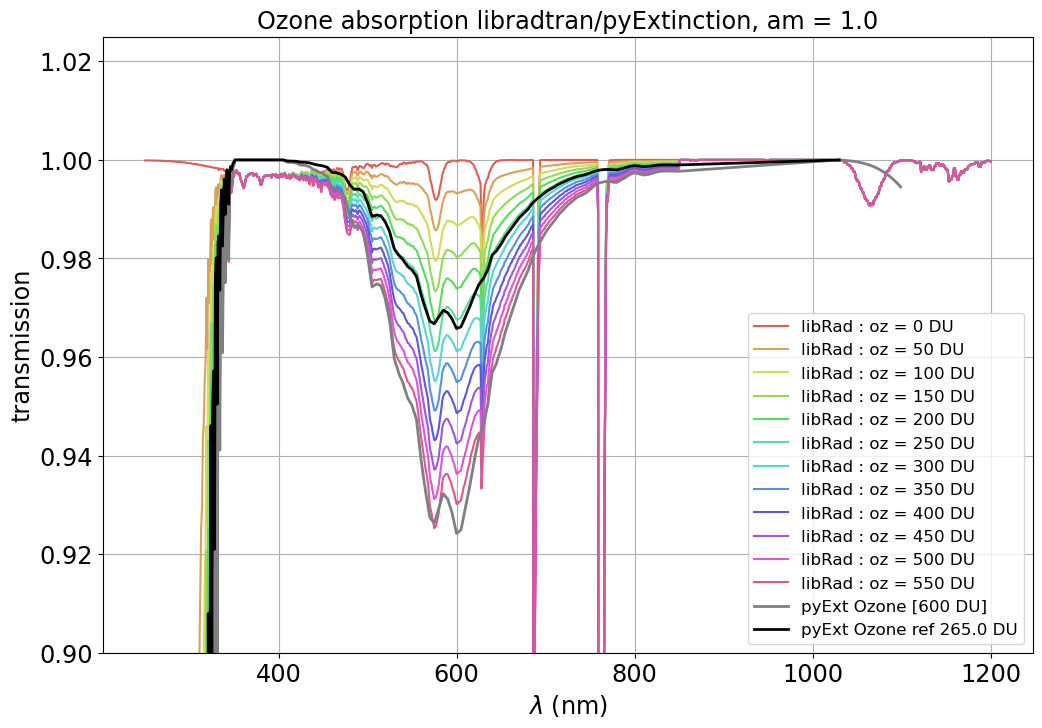

In [22]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()
for idx,oz in enumerate(ozs):

    path,thefile=libsimulateVisible.ProcessSimulation(airmass,pwv,oz,pressure,
                                                      prof_str='us',proc_str='ab',cloudext=cloudext)
    data = np.loadtxt(os.path.join(path,thefile))
    wl = data[:,0]
    transm = data[:,1] 
      
    label = f"libRad : oz = {oz:.0f} DU"
    ax.plot(wl,transm,color=hls_colors[idx],label=label)
    
ax.plot(WL,np.exp(-pyE_opticalindexes[1,:]),color="grey",label=pyE_label2,lw=2)

ax.plot(pyE_xO3ref/10,pyE_yO3ref,color="k",label=pyE_labelO3_ref,lw=2)

ax.set_ylabel("transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title(f"Ozone absorption libradtran/pyExtinction, am = {airmass:.1f}")
ax.grid()
ax.set_ylim(0.9,1.025)

#### Ozone at different airmasses

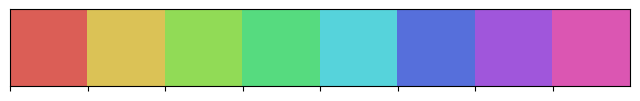

In [23]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

In [24]:
pyE_refO3col

265.0

In [25]:
pyE_pars = np.array([pyE_press,pyE_refO3col,pyE_tau,pyE_ang])
pyE_label1='pyExt Rayleigh [%.0f mbar]' % pyE_press
pyE_label2='pyExt Ozone [%.0f DU]' % pyE_refO3col
pyE_label3=u'pyExt Aerosols [τ=%.4f, å=%.2f]' % (pyE_tau, pyE_ang)
pyE_all_labels = [pyE_label1,pyE_label2,pyE_label3]
pyExt_model.setParams(pyE_pars, dpars=None)
pyE_components_extinctions = pyExt_model.extinctionComponents()
pyE_opticalindexes = EXT2OPT * pyE_components_extinctions

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

(0.8, 1.025)

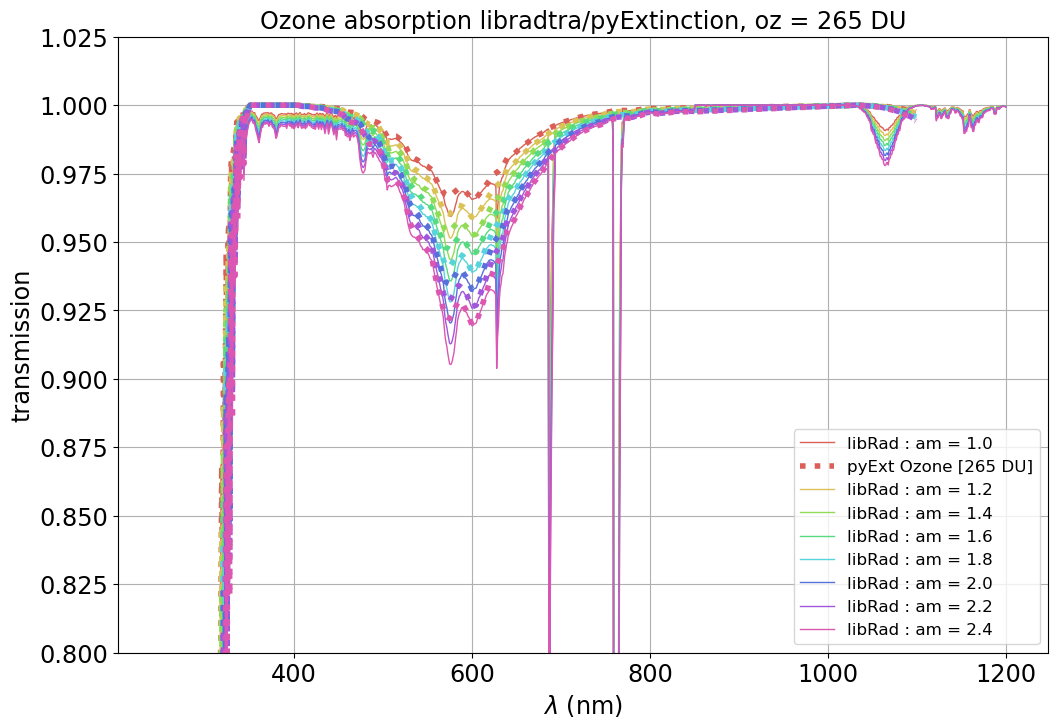

In [26]:
oz= pyE_refO3col
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()

for idx,am in enumerate(airmasses):


    path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,oz,pressure,
                                                      prof_str='us',proc_str='ab',cloudext=cloudext)
    data = np.loadtxt(os.path.join(path,thefile))
    wl = data[:,0]
    transm = data[:,1] 
    
    label = f"libRad : am = {am:.1f}"
    ax.plot(wl,transm,'-',color=hls_colors[idx],label=label,lw=1)

    if idx ==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[1,:]*am),':',color=hls_colors[idx],label=pyE_label2,lw=4)
    else:
        
        ax.plot(WL,np.exp(-pyE_opticalindexes[1,:]*am),':',color=hls_colors[idx],lw=4)



ax.set_ylabel("transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title(f"Ozone absorption libradtra/pyExtinction, oz = {oz:.0f} DU")
ax.grid()
ax.set_ylim(0.8,1.025)

## Check libratran with combined scattering and absorption processes

In [27]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.
path,thefile=libsimulateVisible.ProcessSimulation(am0,pwv,oz0,pressure,
                                                      prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wl1 = data[:,0]
transm1 = data[:,1] 

label0=f"libradtran : airmass = {am0:.1f}, pwv  = {pwv0:.1f} mm , oz = {oz0:.0f} DU"

In [28]:
am1 = 2.0
pwv1 = 5.0
oz1 = 500.
path,thefile=libsimulateVisible.ProcessSimulation(am1,pwv1,oz1,pressure,
                                                      prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wl2 = data[:,0]
transm2 = data[:,1] 

label1=f"libradtran : airmass = {am1:.1f},  pwv  = {pwv1:.1f} mm , oz = {oz1:.0f} DU"

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

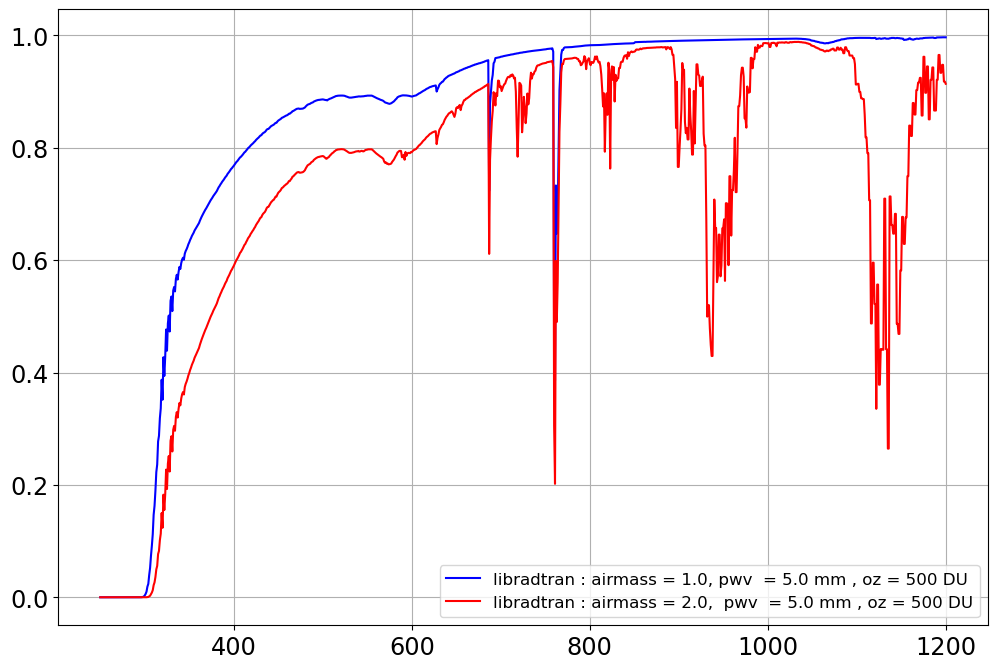

In [29]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()
ax.plot(wl1,transm1,'b-',label=label0)
ax.plot(wl2,transm2,'r-',label=label1)
ax.legend()
ax.grid()

## Check with aerosols

$$
OD = \tau \left( \frac{\lambda_{ref}}{\lambda} \right)^a
$$

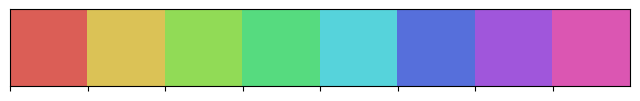

In [30]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

### Aerosols with One Component

#### Parameters for pyExtinction

In [31]:
pyE_tau = 0.05
pyE_ang = 1.3

#### Convert aerosols parameters for AtmEmulator

- not same reference wavelength

In [32]:
taus = [pyE_tau*(1000./550.)**pyE_ang ]
betas = [- pyE_ang]
ncomp=1

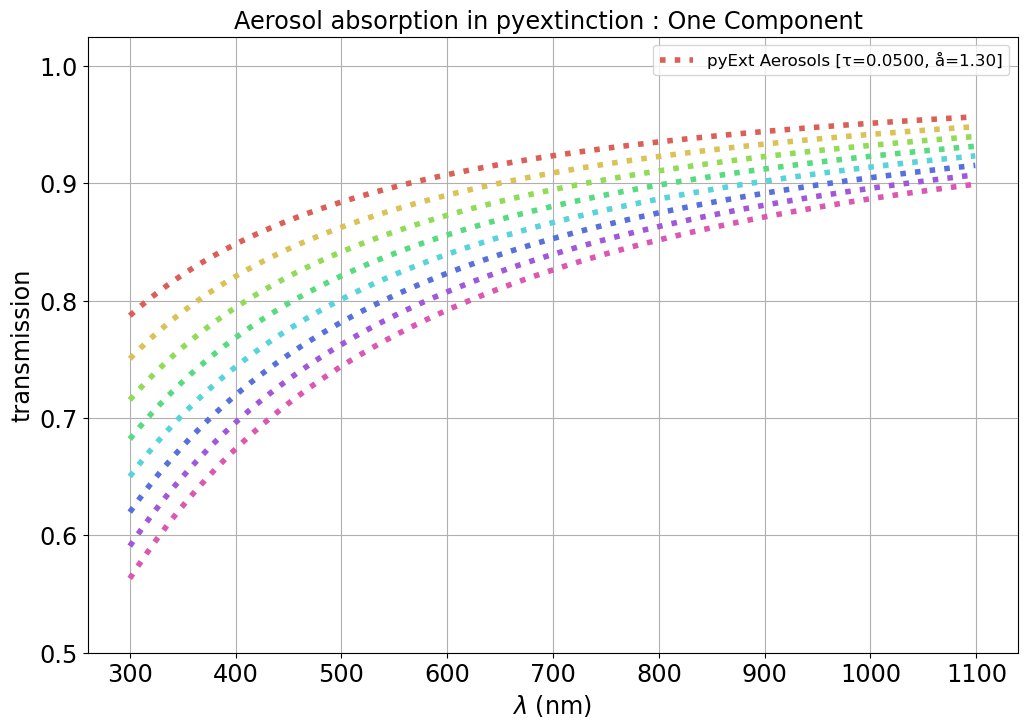

In [33]:
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot()

for idx,am in enumerate(airmasses):

    if idx==0:
        ax.plot(WL,np.exp(-pyE_opticalindexes[2,:]*am),":",color=hls_colors[idx],lw=4,label=pyE_label3) 
    else:
        ax.plot(WL,np.exp(-pyE_opticalindexes[2,:]*am),":",color=hls_colors[idx],lw=4) 
ax.set_ylim(0.5,1.025)
ax.set_ylabel("transmission")
ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.set_title(f"Aerosol absorption in pyextinction : One Component ")
ax.grid()